# Initial Exploration Granovetter

I need to start this for visualization issues. Let's use Jupyter (but I do not want).

In [1]:
import pandas as pd
import numpy as np
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
import pylab as plt #import Matplotlib plotting interface
import networkx as nx
import community # python-louvain

In [2]:
def create_tuple(row):
    '''
    Create a tuple from a row.
    '''
    left = row['wos_id']
    rigth = row['uid']
    tup = (left, rigth)

    return tup

In [3]:
def create_communities(G):
    '''
    Community detection Lauvein algorithm.
    
    Input:
        G = networkX object
    Ouput:
        G = networkX object
    '''
    print("About to create communities.")
    
    communities = community.best_partition(G)
    nx.set_node_attributes(G, communities, 'modularity')
    
    # Print Global Modularity 
    global_modularity = community.modularity(communities, G)
    print("Global modularity: ", global_modularity)
    
    return G

In [4]:
# Six steps:
    # 1) Data
    # 2) Create nodes and edges
    # 3) Create and populate the graph
    # 4) Create the clusters
    # 5) Calculate modularity
    # 6) Graphs

In [5]:
# 1) Data (ALL)
allANDpubyear = pd.read_csv('../output/data/allANDpubyear.txt', sep='\t')

In [68]:
# Define function to do:
# 2) Create nodes and edges
# 3) Create and populate the graph

def save_network(year_0, year_end, allANDpubyear, suffix, del_SWT = False):
    '''
    Creates a network in the defined time span
    
    Inputs:
        year_0 = integer
        year_end = integer
        allANDpubyear = dataframe ['wos_id', 'uid', 
            'citedTitle', 'citedAuthor', 'year',
            'wos_pubyear', 'title']
        suffix = string for the name of the file
        del_SWT = boolean [if true --> delete node STW]
    Output:
        # Saves a network file (.gexf)
        G = graph
    '''
    # Data in the time range
    mask = (allANDpubyear["wos_pubyear"] > year_0 - 1) & (
        allANDpubyear["wos_pubyear"] < year_end + 1)
    all_papers = allANDpubyear[mask]
    
    # Change the names of the nodes
    names1 = all_papers[['wos_id', 'title', 'wos_pubyear']].reset_index(drop=True).rename(
        columns={'wos_id': 'uid', 'wos_pubyear': 'year'})
    names1['author'] = None
    names2 = all_papers[['uid', 'citedTitle', 'year', 'citedAuthor']].reset_index(drop=True).rename(
        columns={'citedTitle': 'title', 'citedAuthor': 'author'})
    names = pd.concat([names1, names2])
    names = names.drop_duplicates()
    names['new_name'] = names['title'].fillna(names['uid'])
    dic_new_names = names.set_index('uid')['new_name'].to_dict()
    
    # Create nodes and edges
    nodes_g = all_papers['wos_id'].append(
        all_papers['uid']).unique()
    edges_g = all_papers.apply(create_tuple, axis=1)
    
    # Create and populate the graph
    G = nx.Graph()
    G.add_nodes_from(nodes_g)
    G.add_edges_from(edges_g)
    
    G = nx.relabel_nodes(G, dic_new_names)
    
    
    # Add author
    names['author'] = names['author'].fillna('Unknow')
    author_dic = dict(zip(names.new_name, names.author))
    nx.set_node_attributes(G, author_dic, 'author')

    # Add year
    names['year'] = names['year'].fillna(1).astype(int)
    year_dic = dict(zip(names.new_name, names.year))
    year_dic = {k:int(v) for k,v in year_dic.items()}
    nx.set_node_attributes(G, year_dic, 'year')
    
    if del_SWT:
        # Delete node SWT
        G.remove_node('THE STRENGTH OF WEAK TIES')
    
    # Create the clusters
    G = create_communities(G)
    
    # Export the data
    nx.write_gexf(G, "../output/graph/{}_{}_{}.gexf".format(year_0, year_end, suffix))
    
    return G
        

In [64]:
graph_1973 = save_network(1973, 1980, allANDpubyear, "att")
graph_1990 = save_network(1990, 1997, allANDpubyear, "att")
graph_2007 = save_network(2007, 2014, allANDpubyear, "att")

graphs = [graph_1973, graph_1990, graph_2007]

About to create communities.
Global modularity:  0.8001717649192565
About to create communities.
Global modularity:  0.8235985931198604
About to create communities.
Global modularity:  0.7102766981211376


In [70]:
graph_1973 = save_network(1973, 1980, allANDpubyear, "no_swt", del_SWT = True)
graph_1990 = save_network(1990, 1997, allANDpubyear, "no_swt", del_SWT = True)
graph_2007 = save_network(2007, 2014, allANDpubyear, "no_swt", del_SWT = True)

graphs = [graph_1973, graph_1990, graph_2007]

About to create communities.
Global modularity:  0.8134495524381301
About to create communities.
Global modularity:  0.8369138868210109
About to create communities.
Global modularity:  0.7203070381552139


In [65]:
for i, g in enumerate(graphs):
    print("********. The num is ", i, "********" )
    num_nodes = g.number_of_nodes()
    num_edges = g.number_of_edges()
    edges_per_node = num_edges / num_nodes
    print("Nodes ", num_nodes)
    print("Edges ", num_edges)
    print("Ratio ", edges_per_node)

********. The num is  0 ********
Nodes  3878
Edges  4912
Ratio  1.2666322846828262
********. The num is  1 ********
Nodes  17921
Edges  23024
Ratio  1.2847497349478265
********. The num is  2 ********
Nodes  171069
Edges  290417
Ratio  1.6976600085345679


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


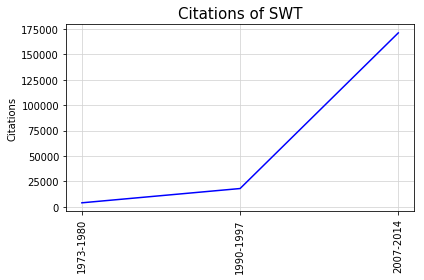

In [100]:
title = "Citations of SWT"
fig, ax = plt.subplots()
plt.subplot(111, facecolor='white')

# plt.xticks(["1973-1980", "1990-1997", "2007-2014"], rotation=90)
# plt.xticks(range(3), ['A', 'Big', 'Cat'], color='red')
plt.xticks([1973, 1990, 2007], ["1973-1980", "1990-1997", "2007-2014"], rotation=90)
plt.plot([1973, 1990, 2007], [3878,17921,171069],color='blue',lw=1.5)
plt.grid(b=True, which='major', color='lightgray', linewidth=.75)
plt.grid(b=True, which='minor', color='lightgray', linewidth=.25)
plt.title(title, fontsize=15)
# plt.xlabel('Year')
plt.ylabel('Citations')
plt.legend(loc=0,fontsize=11)
plt.tight_layout()
plt.show()
fig.savefig("../output/graph/evolution_cites.png", bbox_inches='tight')


plt.close()

In [101]:
17921/3878

4.621196493037648

In [102]:
171069/17921

9.545728474973496

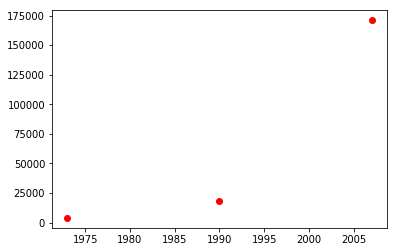

In [81]:
import matplotlib.pyplot as plt
plt.plot([1973,1990,2007], [3878,17921,171069], 'ro')

plt.show()

In [ ]:
# 6) Graphs

# nx.draw(G, node_size = 1)
# nx.draw_random(G, node_size = 1)
# nx.draw_circular(g)
# nx.draw_spectral(g)
# plt.savefig('../output/graph/regions_hopefully.png')
plt.close()


In [ ]:
nx.draw_random(G, node_size = 20)
plt.show()
plt.close()

# Sample to Create a Network Graph

In [327]:
sample = allANDpubyear[["wos_id", "uid"]][allANDpubyear["wos_pubyear"] < 1976]
sample.rename(columns = {"wos_id": "from", "uid": "to"}, inplace = True)
sample = sample.reset_index(drop = True)

In [328]:
nodes = list(set(sample["from"])) + list(set(sample["to"]))
nodes_df = pd.DataFrame(nodes).rename(columns = {0: "id"})

In [329]:
# nodes_df["num"] = np.arange(len(nodes_df))

In [330]:
def create_random_cat(size_df):
    np.random.seed(1234567)
    
    translation = ["Math", "Econ", "Physics", "Ecology", "Business", "Music"]
    
    numbers = np.random.randint(len(translation), size= size_df)
    
    new_list = []
    for num in numbers:
        new_list.append(translation[num])
        
    return new_list    

In [331]:
disciplines = create_random_cat(len(nodes_df))

In [332]:
# nodes_df["type"] = disciplines

In [333]:
sample["w"] = 1

In [341]:
subjects = pd.read_csv("../output/data/subjects.txt", sep="\t").rename(
    columns = {"wos_id": "id"})

In [344]:
nodes_sub = pd.merge(nodes_df, subjects[["id", "subject"]], 
                     left_on = "id", right_on ="id")

In [345]:
c = ["aliceblue", "aquamarine3", "blue", "brown", 
     "chocolate1", "coral", "cyan", "darkgreen", 
     "darkred", "hotpink", "indianred3", "khaki1", 
     "lightseagreen", "lightslateblue", "olivedrab2",
     "seagreen3", "yellow4", "tan2", "yellow3"]

In [346]:
disciplines = list(set(nodes_sub["subject"]))
col_list = []
for s in nodes_sub["subject"]:
    col_list.append(c[disciplines.index(s)])

In [347]:
nodes_sub["color"] = col_list

In [284]:
sample.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/edges.csv", index = None)

In [285]:
nodes_df.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/nodes.csv", index = None)

# Create data for Flexdashboard

In [387]:
s_granovetter = pd.DataFrame(allANDpubyear.groupby("wos_pubyear").count()["year"]).rename(
    columns = {"year": "cites"})
s_granovetter["change"] = s_granovetter.pct_change()
s_granovetter["mean"] = s_granovetter["change"].mean()

In [389]:
s_granovetter.index.name = "year"

In [391]:
s_granovetter.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/evolution.csv")

In [397]:
s_granovetter.loc[2010]["cites"] / s_granovetter.loc[1980]["cites"]


28.649703138252757

## Top authors

### General functions (top authors)

In [559]:
def get_top_in_cat(year_0, year_end, important_var, allANDpubyear):
    '''
    Creates a dataframe with the most important 'important_var'
    '''
    # Data in the time range
    mask = (allANDpubyear["wos_pubyear"] > year_0 - 1) & (
        allANDpubyear["wos_pubyear"] < year_end + 1)
    all_papers = allANDpubyear[mask]

    important_df = pd.DataFrame(all_papers[[important_var, 'year']]
                             ).reset_index(drop=True).rename(
                                columns = {'year': 'count'})

    important_gb = important_df.groupby(important_var).count().sort_values(
        'count', ascending = False)

    if important_var == 'citedAuthor':
        important_gb.loc['Granovetter, M.'] += important_gb.loc['GRANOVET.MS']
        important_gb.drop(['GRANOVET.MS'], inplace = True)

        important_gb.loc['BURT, RS'] += important_gb.loc['BURT RS']
        try: 
            important_gb.loc['BURT, RS'] += important_gb.loc['Burt, RS']  
            important_gb.drop(['Burt, RS'], inplace = True)
        except:
            None
        important_gb.drop(['BURT RS'], inplace = True)
        
        important_gb.loc['LAUMANN, EO'] += important_gb.loc['LAUMANN EO']
        important_gb.drop(['LAUMANN EO'], inplace = True)
        
        try: 
            important_gb.loc['WELLMAN, B'] += important_gb.loc['WELLMAN B']
            important_gb.drop(['WELLMAN B'], inplace = True)
        except:
            None
        try:
            important_gb.loc['WELLMAN, B'] += important_gb.loc['Wellman, B.']
            important_gb.drop(['Wellman, B.'], inplace = True)
        except:
            None
        
        # Drop ALL Granovetters (I build the sample in that way)
        important_gb.drop(['Granovetter, M.'], inplace = True)
        important_gb.drop(['Granovetter, M'], inplace = True)
        important_gb.drop(['GRANOVETTER, M'], inplace = True) 
        important_gb.drop(['GRANOVETTER M'], inplace = True) 
        
    important_gb.sort_values('count', ascending = False, inplace = True)
    important_gb.index = important_gb.index.str.upper()

    return important_gb[:10]

### Get and save (top authors)

In [567]:
# Obtain most cited authors per period
year_0 = 1973
year_end = 1980
important_var = 'citedAuthor'
authors_1973 = get_top_in_cat(year_0, year_end, important_var, allANDpubyear)
authors_1973.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/authors_1973.csv")

In [568]:
# Obtain most cited authors per period
year_0 = 1990
year_end = 1997
important_var = 'citedAuthor'
authors_1990 = get_top_in_cat(year_0, year_end, important_var, allANDpubyear)
authors_1990.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/authors_1990.csv")

In [569]:
# Obtain most cited authors per period
year_0 = 2007
year_end = 2014
important_var = 'citedAuthor'
authors_2007 = get_top_in_cat(year_0, year_end, important_var, allANDpubyear)
authors_2007.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/authors_2007.csv")

## Text

### Functions Text

In [604]:
def save_line(name_file, string, append = True):
    '''
    Saves a line in file.

    Inputs:
        name_file = string (location of file)
        string = string (to save in the file)
        append = boolean (True if append to file)
    '''
    if append:
        f = open(name_file, 'a')
    else:
        f = open(name_file, 'w')
    f.write(string + "\n")
    f.close()

In [605]:
def string_titles(year_0, year_end, allANDpubyear):
    '''
    Generates a string which is the "sum" of all titles.
    '''
    # Data in the time range
    mask = (allANDpubyear["wos_pubyear"] > year_0 - 1) & (
        allANDpubyear["wos_pubyear"] < year_end + 1)
    all_papers = allANDpubyear[mask]

    all_titles = set(all_papers[['title']]['title'])

    one_sentence = " ".join(all_titles).lower()

    return one_sentence

In [606]:
year_0 = 1973
year_end = 1980
titles_1973 = string_titles(year_0, year_end, allANDpubyear)
name_file = "/home/rodrigo/WoS/granovetter/output/data/spring2018/titles_1973.txt"
save_line(name_file, titles_1973, append = False)

In [607]:
year_0 = 1990
year_end = 1997
titles_1990 = string_titles(year_0, year_end, allANDpubyear)
name_file = "/home/rodrigo/WoS/granovetter/output/data/spring2018/titles_1990.txt"
save_line(name_file, titles_1990, append = False)

In [608]:
year_0 = 2007
year_end = 2014
titles_2007 = string_titles(year_0, year_end, allANDpubyear)
name_file = "/home/rodrigo/WoS/granovetter/output/data/spring2018/titles_2007.txt"
save_line(name_file, titles_2007, append = False)

# Relative growth

In [640]:
general_trend = pd.read_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/wc_stats.txt", 
                            header = None, sep = "\s+", names = ["cites_general", "year_file_general"])

In [641]:
general_trend["year"] = np.arange(1985, 2016, 1)
general_trend.drop(["year_file_general"], axis = 1, inplace = True)

In [642]:
general_trend.index = general_trend["year"]
general_trend.drop(["year"], axis = 1, inplace = True)

In [660]:
g_and_g = general_trend.join(s_granovetter)[['cites_general', 'cites']]

In [661]:
g_and_g['trend_g'] = g_and_g['cites_general'] / g_and_g['cites_general'][1985]
g_and_g['trend_swt'] = g_and_g['cites'] / g_and_g['cites'][1985]
g_and_g.drop(['cites_general', 'cites'], axis = 1, inplace = True)

In [663]:
g_and_g.to_csv("/home/rodrigo/WoS/granovetter/output/data/spring2018/trends.csv")